In [3]:
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")



In [4]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.10.0


In [5]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(42,activation='softmax')(x) #FC-layer

In [6]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [7]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [8]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("collected_images//")))
#print(imagePaths)
random.shuffle(imagePaths)


for img in imagePaths:
    path=sorted(list(os.listdir("collected_images/"+img)))
    for i in path:
        image = cv2.imread("collected_images/"+img+'/'+i)
        #print(image.dtype)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        #print(image.shape)
        data.append(image)
        l = label = img
        labels.append(l)
print(labels)

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',

In [9]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

MemoryError: Unable to allocate 1.21 GiB for an array with shape (6616, 128, 128, 3) and data type float32

In [ ]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)
print(xtrain.shape, xtest.shape)

(245, 128, 128, 3) (164, 128, 128, 3)


In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=15),
               steps_per_epoch=xtrain.shape[0] //15,
               epochs=50,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.17221, saving model to model.h5
16/16 - 31s - loss: 2.0476 - accuracy: 0.4522 - val_loss: 1.1722 - val_accuracy: 0.7510 - lr: 0.0010 - 31s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_loss improved from 1.17221 to 0.82740, saving model to model.h5
16/16 - 20s - loss: 0.6464 - accuracy: 0.7696 - val_loss: 0.8274 - val_accuracy: 0.8449 - lr: 0.0010 - 20s/epoch - 1s/step
Epoch 3/50

Epoch 3: val_loss improved from 0.82740 to 0.63318, saving model to model.h5
16/16 - 19s - loss: 0.3303 - accuracy: 0.9087 - val_loss: 0.6332 - val_accuracy: 0.9020 - lr: 0.0010 - 19s/epoch - 1s/step
Epoch 4/50

Epoch 4: val_loss improved from 0.63318 to 0.42163, saving model to model.h5
16/16 - 20s - loss: 0.2462 - accuracy: 0.9174 - val_loss: 0.4216 - val_accuracy: 0.9633 - lr: 0.0010 - 20s/epoch - 1s/step
Epoch 5/50

Epoch 5: val_loss improved from 0.42163 to 0.30929, saving model to model.h5
16/16 - 17s - loss: 0.2709 - accuracy: 0.9087 - val_loss: 0.3093 - 

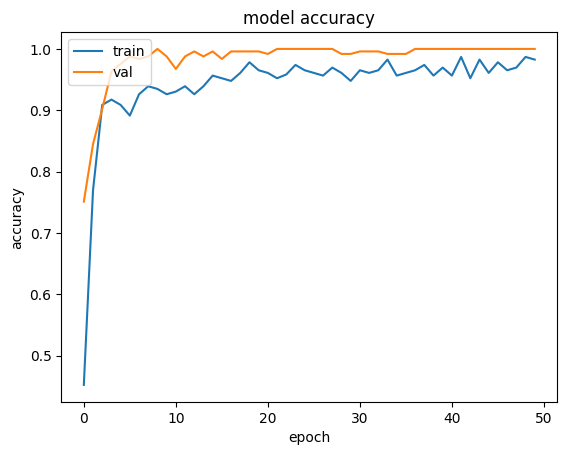

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

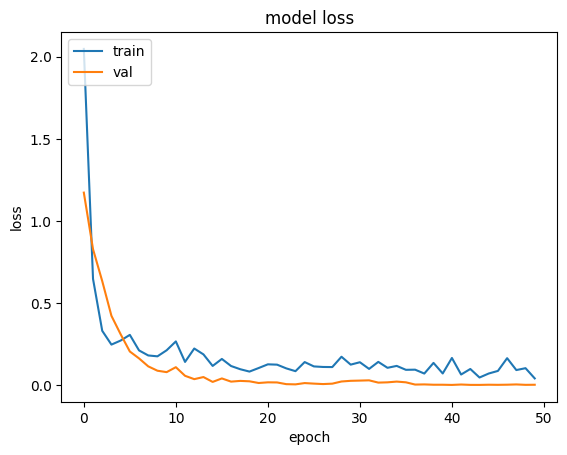

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
ypred = model.predict(xtest)
acc = []
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)  
        
    total += 1
    acc.append(accurate/total*100)
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

6/6 [==============================] - 8s 765ms/step
Total-test-data; 164 	accurately-predicted-data: 163 	 wrongly-predicted-data:  1
Accuracy: 99.39 %


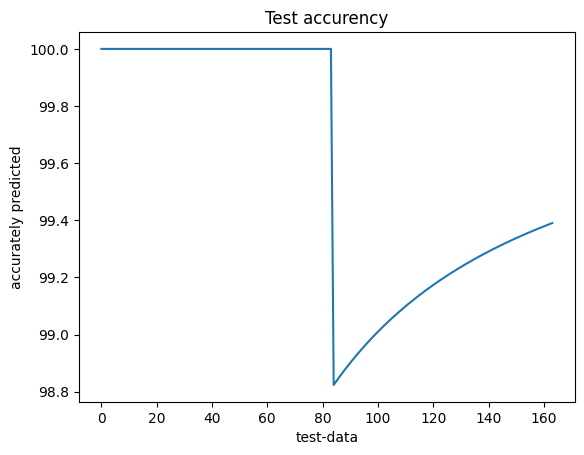

In [ ]:
plt.plot(acc)
plt.plot(100)
plt.title('Test accurency')
plt.ylabel('accurately predicted')
plt.xlabel('test-data')
#plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import os
kl = (os.listdir('collected_images'))
print(kl)
print(len(kl))

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Hello', 'I', 'J', 'K', 'L', 'M', 'Men', 'N', 'No', 'O', 'P', 'Please', 'Q', 'R', 'S', 'T', 'Thanks', 'U', 'V', 'W', 'Women', 'X', 'Y', 'Yes', 'Z']
42


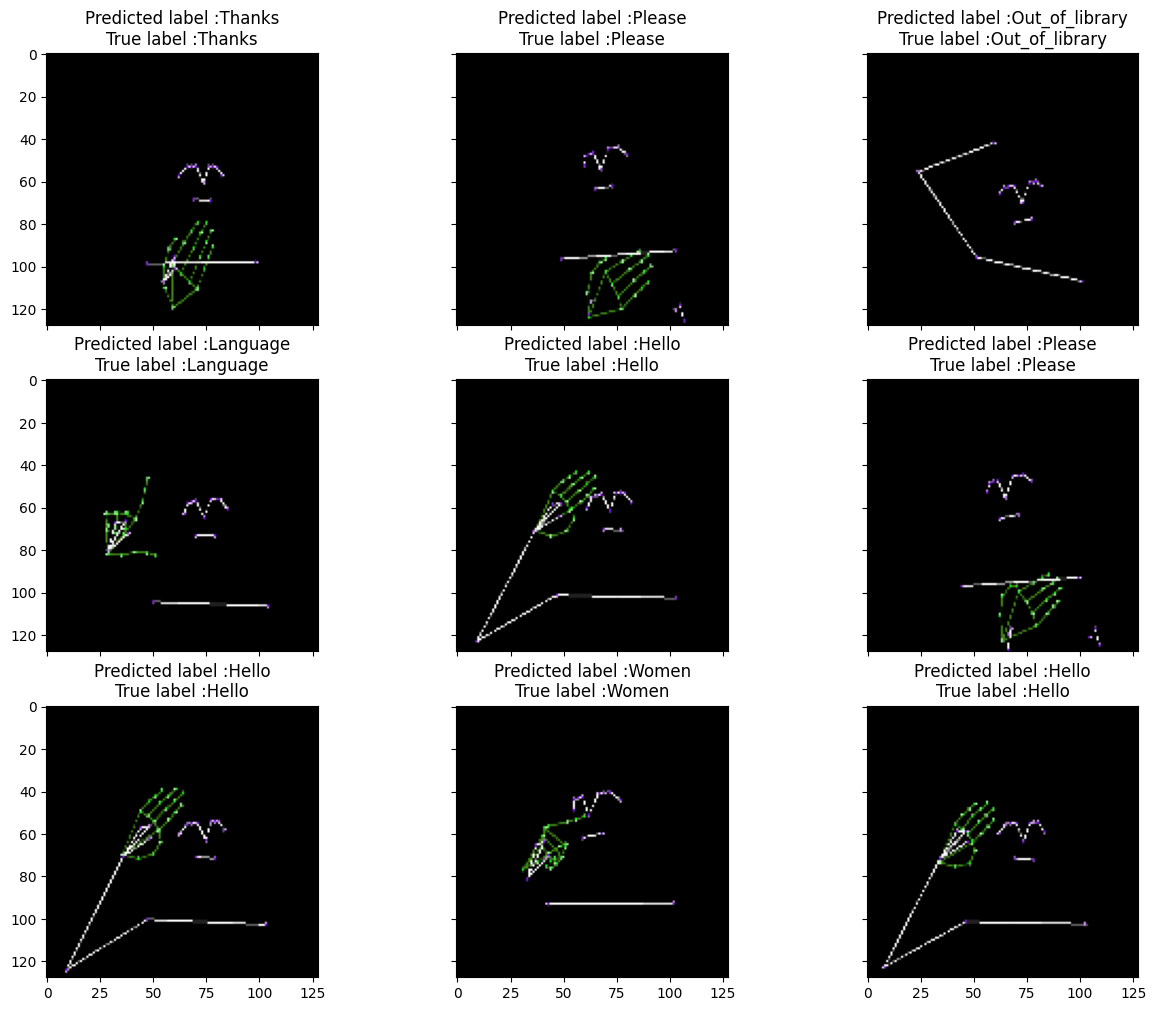

[121, 123, 113, 88, 47, 13, 64, 29, 16]


In [ ]:
label=['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Hello', 'I', 'J', 'K', 'L', 'M', 'Men', 'N', 'No', 'O', 'P', 'Please', 'Q', 'R', 'S', 'T', 'Thanks', 'U', 'V', 'W', 'Women', 'X', 'Y', 'Yes', 'Z']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()
print(imidx)

6/6 [==============================] - 5s 812ms/step


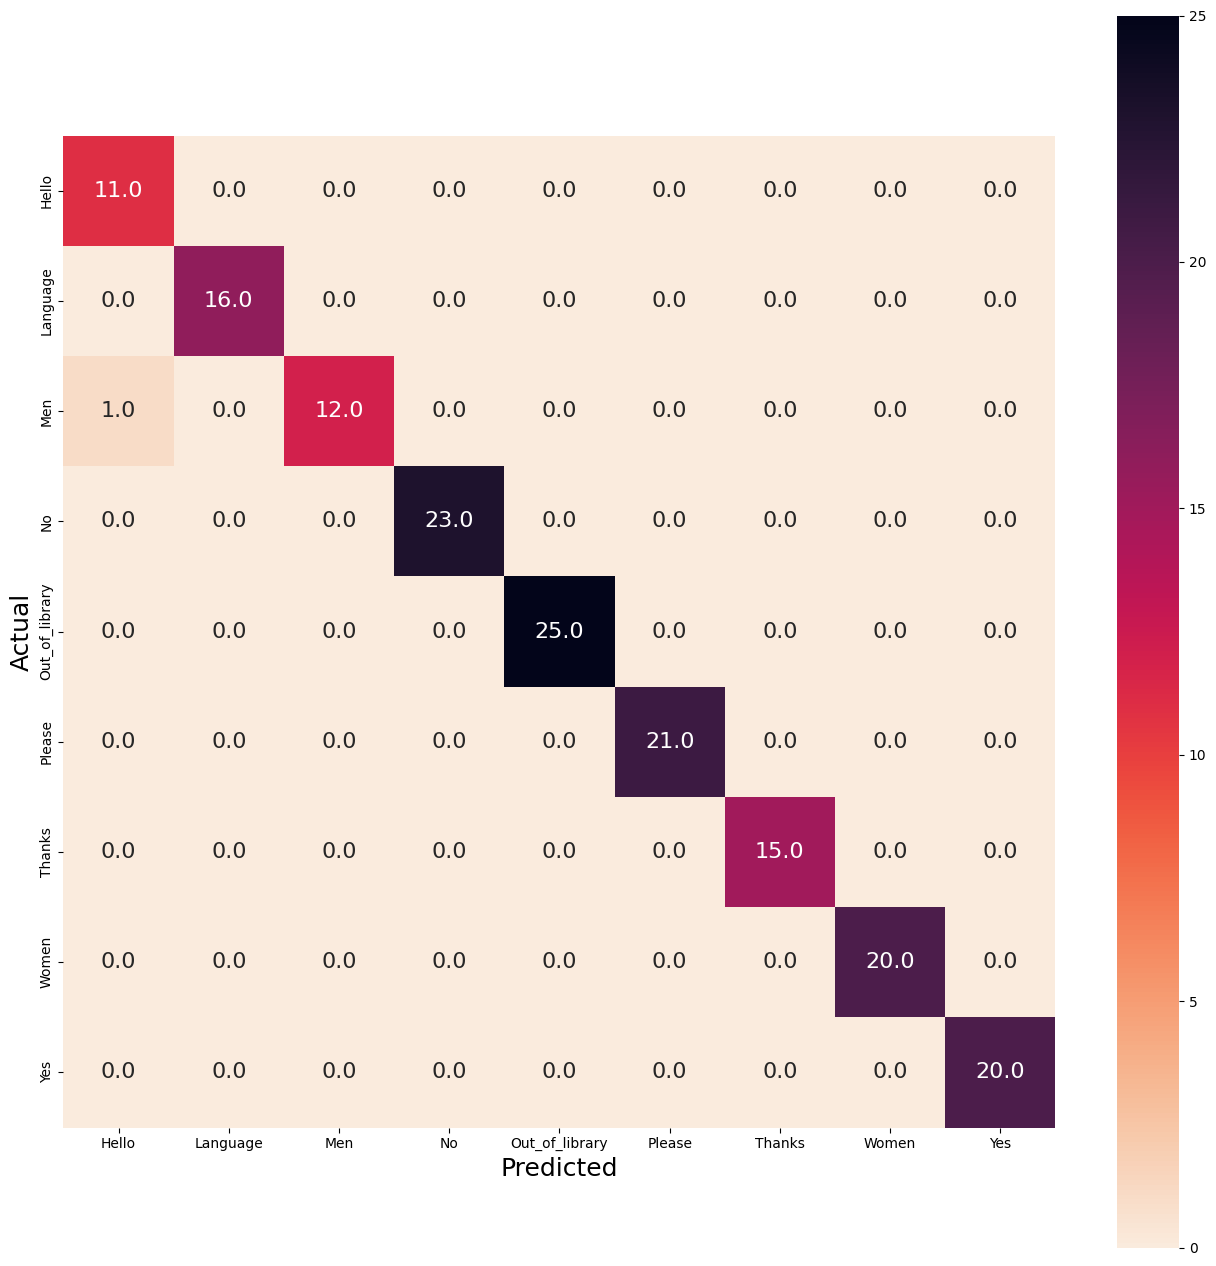

In [ ]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(16, 16))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=18)
ax.set_xlabel('Predicted', fontsize=18)
plt.show()


In [ ]:
pred=[]
image_1=cv2.imread("E:\\PONDICHERRY\\SEM 4\\Project\\new\\collected_images\\Please\Please.7f129416-6163-11ed-a221-cbb402ac3162.jpg")
image_1 = cv2.resize(image_1, (128,128))
image_1 = img_to_array(image_1)
pred.append(image_1)
pred = np.array(pred, dtype="float32") / 255.0
result_1=model.predict(pred)

1/1 [==============================] - 0s 107ms/step


In [ ]:

print("Predicted label :{}\n".format(label[np.argmax(result_1[0])]))


Predicted label :Please



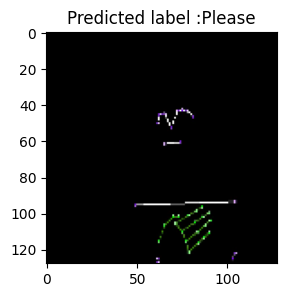

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

n = 0
img=ax.imshow(pred[0])
ax.set_title("Predicted label :{}".format(label[np.argmax(result_1[0])]))
    
plt.show()

In [ ]:
print("Predicted label :{}\nTrue label ".format(label[np.argmax(result_1[0])]))

Predicted label :Please
True label 
